# 使用 `NN` 构建模型

In [15]:
from typing import override
from pathlib import Path
from pickle import load, dump

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.sgd import SGD

import matplotlib.pyplot as plt

## 上一小节实现的数据预处理

In [2]:
class MnistDataset(Dataset):
    @override
    def __init__(self, x:torch.Tensor, y:torch.Tensor) -> None:
        super().__init__()
        if len(x) != len(y):
            raise IndexError('len(x) != len(y)')
        self.x = x
        self.y = y
        return
    
    @override
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index], self.y[index]
    
    @override
    def __len__(self) -> int:
        return len(self.x)
    
    
def readDataset(name:str) -> MnistDataset:
    fullImgPath = f'./mnistData/{name}-images.idx3-ubyte'
    fullLabelPath = f'./mnistData/{name}-labels.idx1-ubyte'

    with open(fullImgPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2051:
            raise ValueError(f'head magic number not equal to 2051: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        dataRow = int.from_bytes(f.read(4))
        dataCol = int.from_bytes(f.read(4))
        
        img = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber*dataRow*dataCol,
            offset=0,
            )
    img.shape = (dataNumber,dataRow * dataCol)
    imgTensor = torch.from_numpy(img).type(torch.float32) / 255
        
    with open(fullLabelPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2049:
            raise ValueError(f'head magic number not equal to 2049: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        
        label = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber,
            offset=0,
            )

    labelOnehotTensor = torch.zeros((len(label), 10), dtype=torch.float32)
    for i,j in zip(label, labelOnehotTensor):
        j[i] = 1
    
    return MnistDataset(imgTensor, labelOnehotTensor)

## 开始构建

### 网络构建

构建一个3层的网络，每一每一层使用`ReLU`作为激活函数

输出没有归一化，因为后面的损失函数输入不需要归一化

In [3]:

model = nn.Sequential(
    nn.Linear(28 * 28, 16, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(16, 16, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(16, 16, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(16, 10, True, dtype=torch.float32),
)

def predict(input):
    return torch.softmax(model(input), dim=1)

criterion = nn.CrossEntropyLoss()
optimisor = SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

### 加载训练集

加载一次训练集之后，打包成`pickle`，下一次使用就不需要重新解析

加快加载速度

In [11]:

trainSetPath = Path("./trainDataset.pickle")

if trainSetPath.exists():
    with open(trainSetPath, "rb") as f:
        trainSet = load(f)
else:
    trainSet = readDataset("train")
    with open(trainSetPath, "wb") as f:
        dump(trainSet, f)

trainDataLoader = DataLoader(trainSet, 20, True)


### 加载已经训练的模块

每次训练完成后保存

如果删除文件则重新训练

In [12]:

modelFile = Path("./modelWithNN.pickle")

if modelFile.exists():
    with open(modelFile, "rb") as f:
        model = load(f)
    print(f"已加载已有模型：{modelFile}")


已加载已有模型：modelWithNN.pickle


### 开始训练

可以选择将新的模型覆盖到旧的模型上，也可以不保存

In [6]:

epochs = 0
for epoch in range(epochs):
    for i, data in enumerate(trainDataLoader):
        output = model(data[0])
        loss: torch.Tensor = criterion(output, data[1])
        optimisor.zero_grad()
        loss.backward()
        optimisor.step()
        if (i + 1) % 100 == 0:
            print(f"loss:{float(loss)}")
    for i in optimisor.param_groups:
        i["lr"] *= 0.3

print("训练完成")

# with open(modelFile, "wb") as f:
#     dump(model, f)

训练完成


### 测试模型的准确度

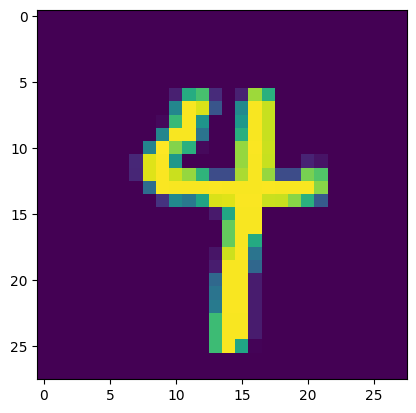

Target: tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
Predict: tensor([[-12.7502,  -4.7528,  -3.2076,   0.9177,   4.7789,  -0.0735,  -4.7361,
           5.8429,   0.1729,   6.6898]], grad_fn=<AddmmBackward0>)
tensor([False])
--------------------


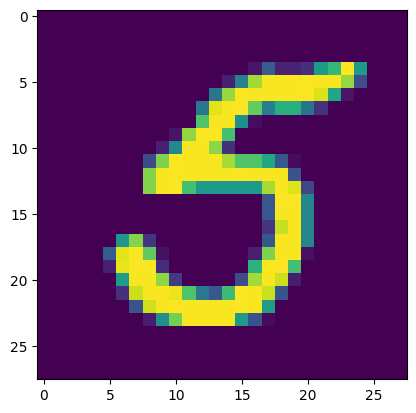

Target: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
Predict: tensor([[ -0.1208, -10.0623,  -2.7859,   5.1600,   3.1040,   8.7724,  -1.1099,
         -12.6391,   2.6735,  -0.7108]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


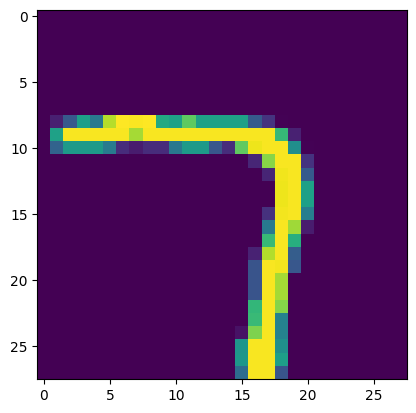

Target: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
Predict: tensor([[-4.2438,  0.7289,  0.8711, -0.5594, -0.5156, -2.7616, -1.9875,  4.8196,
         -0.5205,  2.4210]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


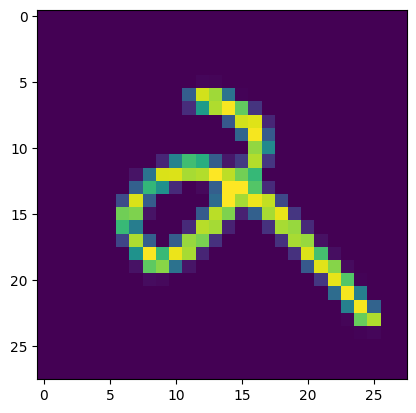

Target: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
Predict: tensor([[-3.6272, -3.6459,  0.0202,  1.6828,  1.1522,  0.8973, -2.1485, -1.4850,
          0.6405,  2.1764]], grad_fn=<AddmmBackward0>)
tensor([False])
--------------------


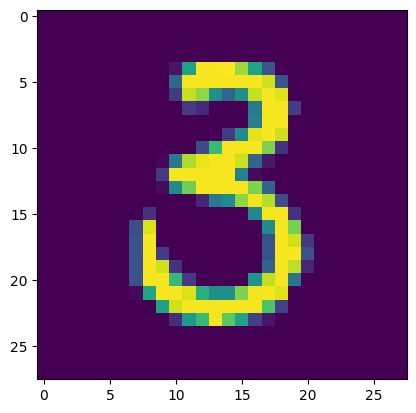

Target: tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
Predict: tensor([[-1.6828, -2.1805,  0.3583,  6.1373, -1.0942,  3.3456, -4.9577, -7.8714,
          2.2199, -0.0748]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


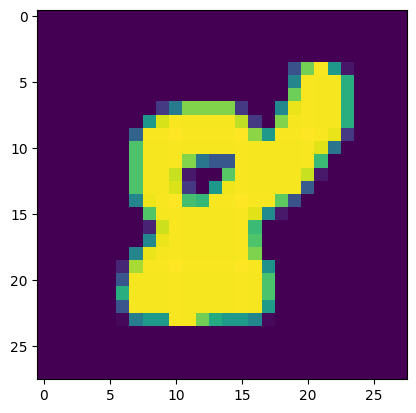

Target: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
Predict: tensor([[-1.8264, -8.3156,  0.3163, -3.3485, -0.3229,  2.1949,  3.3315, -5.7539,
          7.3011, -1.2658]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


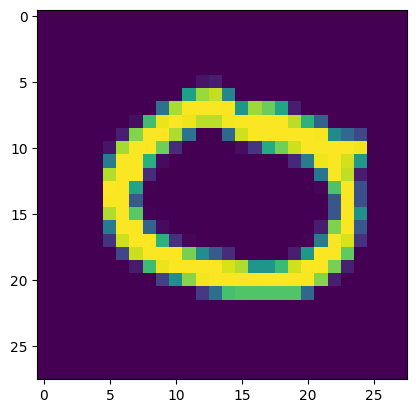

Target: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Predict: tensor([[ 5.7334, -6.0121,  5.1431, -3.4176, -1.5140, -1.2982,  3.2381, -4.8751,
          0.9627, -2.8687]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


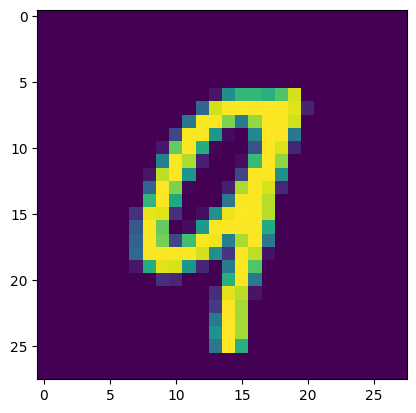

Target: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
Predict: tensor([[-6.7835, -9.3729,  0.2199, -1.5839,  3.7794, -0.9383, -0.8464,  2.3780,
          1.4519,  5.4934]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


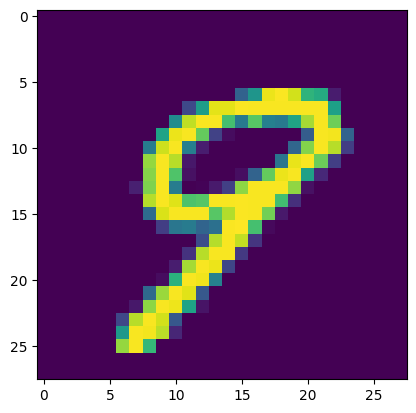

Target: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
Predict: tensor([[-10.2941,  -4.9181,  -0.8031,   1.3420,   2.2972,  -0.5419,  -4.6992,
           2.3092,   2.4655,   5.6029]], grad_fn=<AddmmBackward0>)
tensor([True])
--------------------


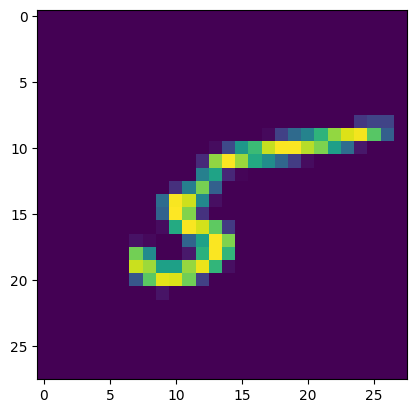

Target: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
Predict: tensor([[ 0.1135, -1.7653, -0.3022, -0.9134, -0.8068,  1.8607,  1.2785, -3.0147,
          2.0835, -1.7801]], grad_fn=<AddmmBackward0>)
tensor([False])
--------------------
正确率14.528333333333334%


In [18]:
testSet = readDataset("t10k")
testDataLoader = DataLoader(testSet, batch_size=1, shuffle=True)

showCount = 0

correctorchount = 0
for data in testDataLoader:
    output: torch.Tensor = model(data[0])
    correction: torch.Tensor = output.argmax(1) == data[1].argmax(1)
    correctorchount += int(correction.sum(dtype=torch.int32))
    if showCount < 10:
        showCount += 1
        plt.imshow(data[0].reshape((28,28)))
        plt.show()
        print(f'Target: {data[1]}')
        print(f'Predict: {output}')
        print(correction)
        print('-'*20)


print(f"正确率{correctorchount/600}%")
